# MolMIM Inferencing for Generative Chemistry and Downstream Prediction

Note: This notebook was tested on a single A100 GPU using BioNeMo Framework v1.6.

## Demo Objectives

1. **MolMIM inferencing and integration with RDKit**
    * Objective: Generate hidden state representations and embeddings from SMILES strings
2. **Molecular generation**
    * Objective: Explore the chemical space by generating new molecules based on a seed SMILES string
3. **Downstream prediction using MolMIM embeddings**
    * Objective: Generate an ESOL water solubility prediction model from MolMIM embeddings

## Setup

Please ensure that you have read through the Getting Started section, can run the BioNeMo Framework docker container, and have configured the NGC Command Line Interface (CLI). It is assumed that this notebook is being executed from within the container.

<div class="alert alert-block alert-info"> <b>NOTE</b> Some of the cells below generate long text output.  We're using <pre>%%capture --no-display --no-stderr cell_output</pre> to suppress this output.  Comment or delete this line in the cells below to restore full output.</div>


### Import Required Libraries

In [1]:
%%capture --no-display --no-stderr cell_output

import os

# RDKit for handling/manipulating chemical data
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

from bionemo.utils.hydra import load_model_config
from bionemo.model.molecule.molmim.infer import MolMIMInference

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import logging
logging.basicConfig(level = logging.INFO)
logging.getLogger("nemo_logger").setLevel(logging.ERROR)

### Home Directory

Set the home directory as follows:

In [2]:
bionemo_home = "/workspace/bionemo"
os.environ['BIONEMO_HOME'] = bionemo_home
os.chdir(bionemo_home)

### Download Model Checkpoints

Now, download the pre-trained MolMIM model checkpoints:

In [3]:
%%capture --no-display --no-stderr cell_output
!python download_artifacts.py --model_dir ${BIONEMO_HOME}/models --models molmim_70m_24_3

## MolMIM Inference Functions

In this section, we will explore the key inference functionalities of the pre-trained model. These functionalities include inputting SMILES strings, obtaining latent space representations with `seq_to_hiddens()`, embeddings with `seq_to_embeddings()`, and outputting inferred SMILES strings from the latent space representation with `hiddens_to_seq()`.

### Load Configurations

Here, we load pre-trained model checkpoints and point the YAML configuration file to the desired checkpoints path. We then initiate a model with `MolMIMInference`, which is an adaptor that allows interaction with the inference service of a MolMIM pre-trained model.

In [4]:
%%capture --no-display --no-stderr cell_output

# Load pre-trained model checkpoints
checkpoint_path = f"{bionemo_home}/models/molecule/molmim/molmim_70m_24_3.nemo"

# Load starting config for MolMIM inference
cfg = load_model_config(config_name="molmim_infer.yaml", config_path=f"{bionemo_home}/examples/tests/conf/")

# Point YAML configuration file to the location of the desired checkpoints
cfg.model.downstream_task.restore_from_path = checkpoint_path
#cfg.model.encoder.hidden_steps = 2

# Create model object based on desired configuration
model = MolMIMInference(cfg, interactive=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
24-08-06 21:31:25 - PID:1550 - rank:(0, 0, 0, 0) - microbatches.py:39 - INFO - setting number of micro-batches to constant 1


### SMILES Examples with RDKit

Here, as an example, we will take the SMILES strings for two widely used antimalarial drugs, Mefloquine and Hydroxychloroquine, and use RDKit, an open-source cheminformatics library, to display the molecues.

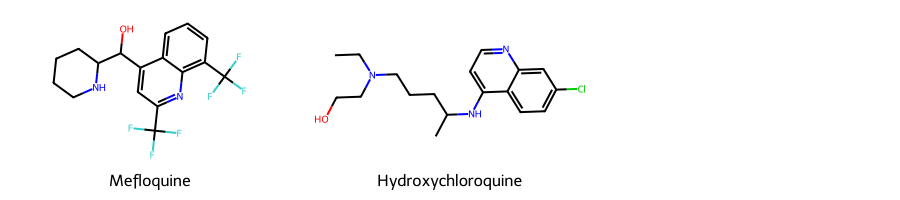

In [5]:
# Two SMILES strings
smis = ['OC(c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)C1CCCCN1',     
        'CCN(CCO)CCCC(C)Nc1ccnc2cc(Cl)ccc12'] 

# RDKit's MolFromSmiles() function displays molecule from the SMILES string
m1 = Chem.MolFromSmiles(smis[0])
m2 = Chem.MolFromSmiles(smis[1])
Draw.MolsToGridImage((m1,m2), legends=["Mefloquine","Hydroxychloroquine"], subImgSize=(300,200))

### From SMILES to Hidden State

We now run inference with MolMIM to find the hidden states of our starting molecules. The `seq_to_hiddens()` functionality, accessed through the `MolMIMInference` wrapper, queries the model to fetch the latent space representation of the SMILES. The MolMIM hidden state has a controlled number of tokens since it uses a Perceiver encoder, so no pooling is necessary to create a fixed size embedding.

A high level conceptual depiction below shows the process of obtaining the hidden states.

![molmim-hidden-state](./images/molmim-hidden-state.png)

In [6]:
# obtaining the hidden state representations for input SMILES
hidden_states, pad_masks = model.seq_to_hiddens(smis)
hidden_states.shape, pad_masks.shape

(torch.Size([2, 1, 512]), torch.Size([2, 1]))

Note that for MolMIM, the hidden state dimension $K$ is equal to 1, as MolMIM’s best effective novelty (the percentage of generated molecules that are valid, non-identical, unique, and novel) was achieved using the smallest number of latent dimensions. More details can be found in the [paper](https://arxiv.org/pdf/2208.09016).

Thus, in the next step, we should expect the embedding vectors to be equal to the hidden states.

### From SMILES to Embedding

We can use `seq_to_embeddings()` to query the model and fetch the encoder embeddings for the input SMILES strings. They are the same as the hidden state in the case of MolMIM.

In [7]:
embedding = model.seq_to_embeddings(smis)
embedding.shape

torch.Size([2, 512])

### Hidden State to SMILES

The `hiddens_to_seq()` function is used to obtain SMILES from the latent space chemical representation. Let's see if the decoder turns the hidden state representations of our two example compounds back into the same SMILES strings, or similar.

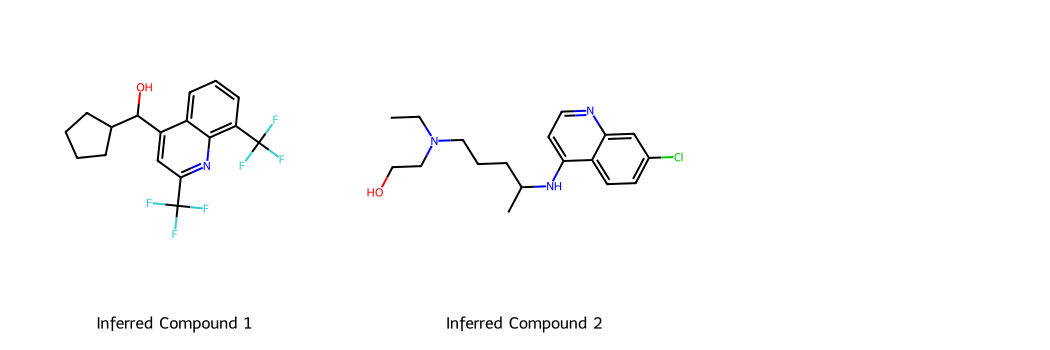

In [8]:
# Obtaining SMILES chemical representation from a hidden state
inferred_smis = model.hiddens_to_seq(hidden_states, pad_masks)

inf_1 = Chem.MolFromSmiles(inferred_smis[0])
inf_2 = Chem.MolFromSmiles(inferred_smis[1])

Draw.MolsToGridImage((inf_1,inf_2),legends=["Inferred Compound 1","Inferred Compound 2"], subImgSize=(350,350))

Let's check if they are the same compounds:

In [9]:
print("Compund 1:", smis[0]==inferred_smis[0])
print("Compund 2:", smis[1]==inferred_smis[1])

Compund 1: False
Compund 2: True


Note that the second compound is the same, and the first one is similar, but not the same as the input.

## Molecular Generation and Chemical Space Exploration

Now, we will explore the chemical space around an input compound and generate designs of related but novel small molecules.

### Define Generation Function 

We will specify a function, `chem_sample()`, to accomplish this. `chem_sample()` has two main components:
1. **Sampling:** Obtain the hidden state representation for the input SMILES, perturb copies of this hidden states, and decode those perturbed hidden states to obtain new SMILES. Note that the sampling function, `sample()`, is defined in the `BaseEncoderDecoderInference` class, which `MolMIMInference` abstracts from.
2. **Filtering:** Using RDKit, check the uniqueness of the generated SMILES set and retain those that are valid SMILES.

In [10]:
def chem_sample(smis):
    # PART 1: SAMPLING
    # 1A: Set Sampling Arguments
    num_samples = 10
    scaled_radius = 0.7
    sampling_method="beam-search-perturbate" # Options: greedy-perturbate, topkp-perturbate, beam-search-perturbate, beam-search-single-sample, beam-search-perturbate-sample
    sampler_kwargs = {"beam_size": 3, "keep_only_best_tokens": True, "return_scores": False}    
    # 1B: Execute sampling
    population_samples = model.sample(seqs=smis, num_samples=num_samples, scaled_radius=scaled_radius,
                                      sampling_method="beam-search-perturbate", **sampler_kwargs)

    # PART 2: FILTERING
    uniq_canonical_smiles = []
    # Loop through each seed molecule
    for smis_samples, original in zip(population_samples, smis):
        # 2A: Gather unique strings (remove duplicates and starting string)
        smis_samples = set(smis_samples) - set([original])

        # 2B: Validate generated molecules
        valid_molecules = []
        for smis in smis_samples:
            mol = Chem.MolFromSmiles(smis)
            if mol:
                valid_molecules.append(Chem.MolToSmiles(mol,True))
        uniq_canonical_smiles.append(valid_molecules)
    return uniq_canonical_smiles # List (len = seed compounds) of lists (len = generated compounds per seed)

### Generate and Visualize Analogous Small Molecules

In this step, we will use the same two example drug molecules, mefloquine and hydroxychloroquine, and generate new analogues.

In [11]:
# Redefine inputs and generate new molecules
ori_smis_lst = ['OC(c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)C1CCCCN1',
                'CCN(CCO)CCCC(C)Nc1ccnc2cc(Cl)ccc12'] 

gen_smis_lst = chem_sample(ori_smis_lst)

for ori_smis, gen_smis in zip(ori_smis_lst, gen_smis_lst):
        print(f"Original SMILES: {ori_smis}")
        print(f"Generated {len(gen_smis)} unique/valid SMILES: {gen_smis}")
        print("\n")

Original SMILES: OC(c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)C1CCCCN1
Generated 10 unique/valid SMILES: ['O=C(O)C(F)(F)CCCNS(=O)(=O)c1ccccc1', 'OC[C@@H]1C[C@H](NC(F)(F)F)C12CCC2', 'OCc1ccc(C(F)(F)F)nc1N(Cc1ccccc1)c1ccccc1', 'OCc1ncc(C(F)(F)F)nc1N(C[C@H]1CCCO1)CC(F)(F)F', 'OC(c1cc(C(F)(F)F)ncc1Cl)(C(F)F)N1CCCCCC1', 'OC(c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)C1CCCC1', 'OCc1ncc(C(F)(F)F)nc1N(CC(F)(F)F)C1CC1', 'O[C@@H](c1cc(C(F)(F)F)ncn1)C(F)(F)Br', 'OC(c1c(NC[C@H]2CCOC2)nc2ccccn12)(C1CC1)C1CC1', 'OC(c1csc(Br)c1)c1cc(C(F)(F)F)ncn1']


Original SMILES: CCN(CCO)CCCC(C)Nc1ccnc2cc(Cl)ccc12
Generated 9 unique/valid SMILES: ['CCN(CCO)CCCC(=O)N1CCSc2cc(Cl)ccc21', 'CCN(CCO)CCNC(=O)c1ccnc2cc(Cl)ccc12', 'CCN(CCO)CCCCN(C)c1ccnc2cc(Cl)ccc12', 'CCN(CC(=O)NC)C[C@H](N)c1nc2cc(Cl)ccc2s1', 'CCN(CCO)CCCC(=O)N1CCNc2cc(Cl)ccc21', 'CCN(CCO)CCCC(=O)Nc1cnc2cc(Cl)ccc2n1', 'CCN(CCO)CCCC(=O)Nc1cnc2cc(Cl)ccn12', 'CCN(CCO)CCC[C@@H](C)Nc1ccnc2c(Cl)cccc12', 'CCN(CCO)CCCC(=O)N[C@H](C)c1cc(Cl)cc2c1OCC2']




Let's take a look at the generated analogs for mefloquine.

Total unique molecule designs obtained:  10


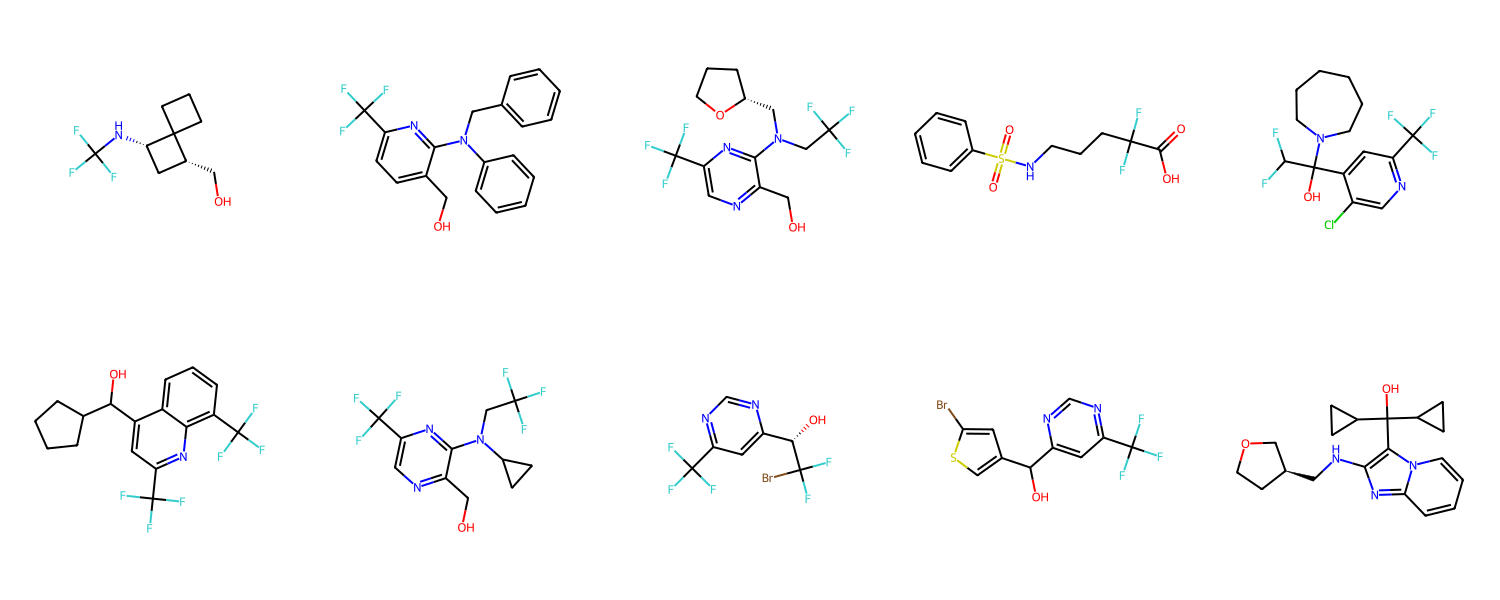

In [12]:
mols_from_gen_smis = [Chem.MolFromSmiles(smi) for smi in set(gen_smis_lst[0])]
print("Total unique molecule designs obtained: ", len(mols_from_gen_smis))
Draw.MolsToGridImage(mols_from_gen_smis, molsPerRow=5, subImgSize=(300,300))

How many molecular designs were obtained from this step? What would change in the process if you try different values for number of samples and sampling radius in the `chem_sample()` function?

## Downstream Prediction Model Using Learned Embeddings from MolMIM

Finally, we will use MolMIM to obtain embeddings for a chemical dataset, to be used as features to train a downstream machine learning model to predict properties of the compounds.

These properties may include physicochemical parameters, such as lipophilicity (LogP and LogD), solubility, and hydration free energy. These properties can also include certain pharmacokinetic/dynamic behaviors such as Blood-Brain-Barrier/CNS permeability, volume of distribution (Vd), etc.

In the section below, we use the ESOL water solubility dataset curated by [MoleculeNet](https://moleculenet.org/datasets-1), which displays water solubility for common organic small molecules in `log solubility in mols per liter`.

![molmim-predictive-modeling](./images/molmim-predictive-modeling.png)

### Data Loading and Preprocessing

We first download the ESOL data.

In [13]:
%%capture --no-display --no-stderr cell_output
!mkdir -p "${BIONEMO_HOME}/data/raw"
!wget -O ${BIONEMO_HOME}/data/raw/delaney-processed.csv https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv

We now load and preprocess the data.

In [14]:
ex_data_file = f"{bionemo_home}/data/raw/delaney-processed.csv"
ex_df = pd.read_csv(ex_data_file)
print(ex_df.shape)
ex_df.head()

(1128, 10)


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


### Obtain Embeddings

We will now obtain the embeddings for compounds that are present in the dataset by using the previously introducted `seq_to_embeddings()` function.

In [15]:
ex_emb_df = pd.DataFrame()
smis = ex_df.loc[:, 'smiles']
esol = ex_df.loc[:, 'ESOL predicted log solubility in mols per litre']
embedding = model.seq_to_embeddings(smis.tolist())
ex_emb_df = pd.concat([ex_emb_df,
                       pd.DataFrame({"SMILES": smis,
                                     "EMBEDDINGS": embedding.tolist(),
                                     "Y": esol})])

ex_emb_df

,SMILES,EMBEDDINGS,Y
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,"[0.4135575294494629, 0.4625270664691925, 0.582...",-0.974
1,Cc1occc1C(=O)Nc2ccccc2,"[-0.1996016651391983, -0.0787326991558075, -0....",-2.885
2,CC(C)=CCCC(C)=CC(=O),"[-0.4746260643005371, -0.8526585102081299, -0....",-2.579
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,"[-0.2653975486755371, -0.1304905116558075, 0.1...",-6.618
4,c1ccsc1,"[-0.5700850486755371, -0.8756077289581299, 0.1...",-2.232
...,...,...,...
1123,FC(F)(F)C(Cl)Br,"[0.1985916942358017, 0.2149684727191925, -0.07...",-2.608
1124,CNC(=O)ON=C(SC)C(=O)N(C)C,"[-0.0939498096704483, 0.9334743022918701, -0.3...",-0.908
1125,CCSCCSP(=S)(OC)OC,"[0.6227860450744629, 0.4312770664691925, 0.255...",-3.323
1126,CCC(C)C,"[0.2175125926733017, 0.1398952305316925, -0.07...",-2.245


### SVR Model: Predicting ESOL Using MolMIM Embeddings

Now that we have both the embeddings for the ESOL dataset, we can generate a prediction model. Here, we will be creating a Support Vector Regression (SVR) model.

In [16]:
# Splitting dataset into training and testing sets
tempX = np.asarray(ex_emb_df['EMBEDDINGS'].tolist(), dtype=np.float32)
tempY = np.asarray(ex_emb_df['Y'], dtype=np.float32)
x_train, x_test_emb, y_train, y_test_emb  = train_test_split(tempX, tempY, train_size=0.7, random_state=1993)

# Defining SVR model parameters (you may change them and observe change in performance)
reg_emb = SVR(kernel='rbf', gamma='scale', C=10, epsilon=0.01)

# Fitting the model on the training dataset
reg_emb.fit(x_train, y_train)

# Using the fitted model for prediction of the ESOL values on test dataset
pred_emb = reg_emb.predict(x_test_emb)

# Performance measures of SVR model
emb_SVR_MSE = mean_squared_error(y_test_emb, pred_emb)
emb_SVR_R2 = r2_score(y_test_emb, pred_emb)

print("Embeddings_SVR_MSE: ", emb_SVR_MSE)
print("Embeddings_SVR_r2: ", emb_SVR_R2)

Embeddings_SVR_MSE:  0.8602563849908824
Embeddings_SVR_r2:  0.7037909732430953


### Results

Now that the SVR model has been trained with an $R^2$ of 0.70, let's assess the result by plotting the predicted vs. actual ESOL values in the test set.

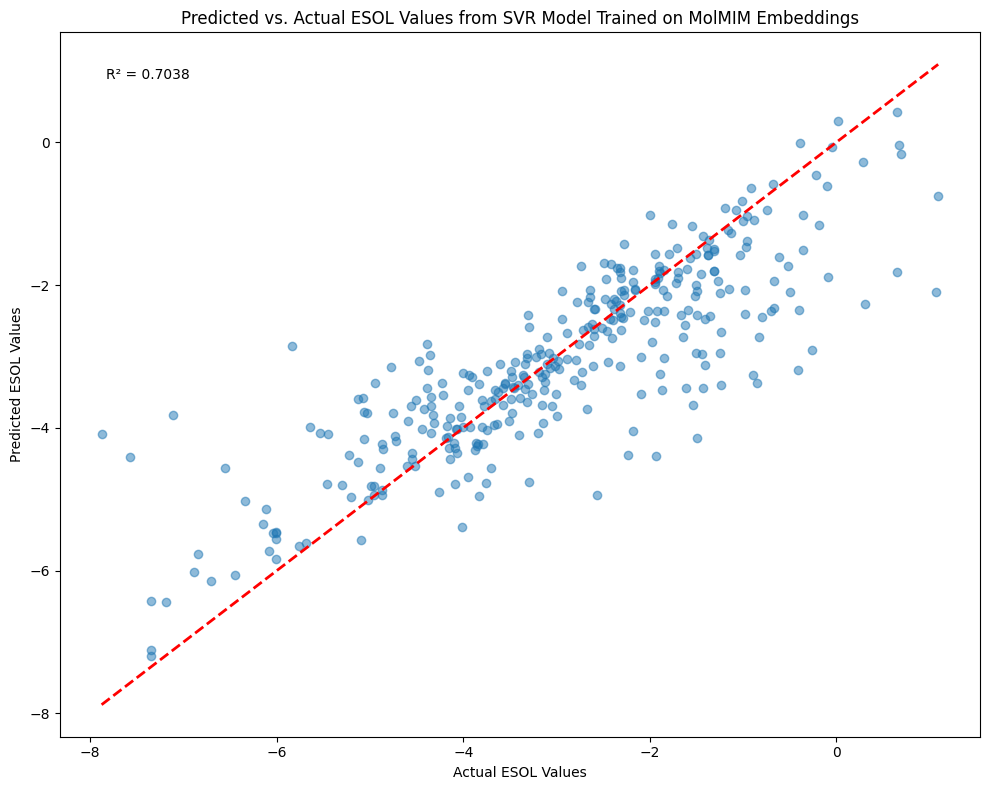

In [17]:
# Create the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(y_test_emb, pred_emb, alpha=0.5)

# Add a diagonal line representing perfect predictions
min_val = min(min(y_test_emb), min(pred_emb))
max_val = max(max(y_test_emb), max(pred_emb))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

# Set labels and title
plt.xlabel('Actual ESOL Values')
plt.ylabel('Predicted ESOL Values')
plt.title('Predicted vs. Actual ESOL Values from SVR Model Trained on MolMIM Embeddings')

# Add R-squared value to the plot
plt.text(0.05, 0.95, f'R² = {emb_SVR_R2:.4f}', transform=plt.gca().transAxes, 
         verticalalignment='top')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

We can see that the SVR model makes moderate predictions of solubility through using the MolMIM embeddings as predictors. Can you tweak and improve the model?